In [1]:
from mdss.ScoringFunctions.Bernoulli import Bernoulli
from mdss.ScoringFunctions.Poisson import Poisson
from mdss.MDSS import MDSS

import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype

import warnings

warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('../project2_data_21_04_23.csv').drop(columns = 
       ['Unnamed: 0','study_id']).fillna(-999)
# target_cols = ['htn_jnc7_qc', 'diabetes_status_c_qc', 'ckd_c_qc', 'cadiovascular_current']
# target_cols = ['htn_jnc7_qc', 'diabetes_status_c_qc']
target_cols = ['diabetes_status_c_qc']

In [3]:
numeric_columns = [col for col in data.columns \
                     if (is_numeric_dtype(data[col])) \
                     & (col not in target_cols) \
                     & (data[col].nunique() > 10)]

In [17]:
site_id = 1 # 1 - Agincourt, 3 - Nairobi

# Choose the relevant site and age group
dff = data[(data['site'] == site_id) & (data['age'] <= 60) & (data['age'] >= 40)].fillna(-999)

print('Original size: ', dff.shape)
dff = dff[(dff[target_cols] != -999).sum(axis = 1) == len(target_cols)].copy()
print('Size after removing records with missing targets: ', dff.shape)

Original size:  (1465, 25)
Size after removing records with missing targets:  (1465, 25)


In [18]:
dff.loc[:,'ckd_c_qc'] = dff.loc[:,'ckd_c_qc'].replace([-999], 0)
dff1 = dff.replace([-999, -222, -111, 999], np.nan).copy()

<Axes: ylabel='Density'>

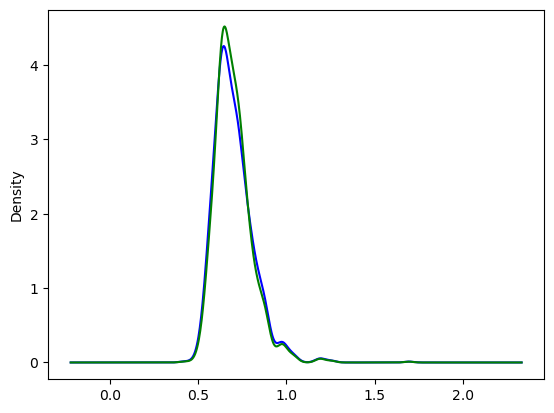

In [19]:
from sklearn.linear_model import BayesianRidge
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import matplotlib.pyplot as plt
imputer_bayes = IterativeImputer(
    estimator=BayesianRidge(),
    max_iter=10,
    random_state=42)

# let's create a MICE imputer using Bayes as estimator

imputer = IterativeImputer(
    estimator=BayesianRidge(), # the estimator to predict the NA
    initial_strategy='mean', # how will NA be imputed in step 1
    max_iter=10, # number of cycles
    imputation_order='ascending', # the order in which to impute the variables
    n_nearest_features=None, # whether to limit the number of predictors
    skip_complete=True, # whether to ignore variables without NA
    random_state=0,
)
imputer.fit(dff1)
train_t = imputer.transform(dff1)
# train_x = imputer.transform(data.iloc[:,2:])
treated = pd.DataFrame(train_t, columns=dff1.columns)
# treated = treated.apply(np.ceil)
treated.loc[:,['highest_level_of_education_qc','occupation_qc','smoking_status_c_qc']]\
      = np.round(treated.loc[:,['highest_level_of_education_qc','occupation_qc','smoking_status_c_qc']], decimals=0)

fig = plt.figure()
ax = fig.add_subplot(111)
dff1['cimt_mean_max'].plot(kind='kde', ax=ax, color='blue')
treated['cimt_mean_max'].plot(kind='kde', ax=ax, color='green')

In [20]:

# target = 'MorbidityCount'

# Specify the columns of interest
columns_of_interest = ['htn_jnc7_qc', 'diabetes_status_c_qc', 'ckd_c_qc', 'cadiovascular_current'] 

# defining the outcome variable
treated['MorbidityCount'] = (treated[columns_of_interest] == 1).sum(axis = 1) # *******CHECK**********

# Min-Max Normalization
treated['normalizedOutcome'] = (treated['MorbidityCount'] - treated['MorbidityCount'].min()) / (treated['MorbidityCount'].max() - treated['MorbidityCount'].min())


# defining the expectations as mean of the target
# treated['expectation'] = treated[target_col].mean()
treated['expectationPoisson'] = treated['normalizedOutcome'].mean()
# treated['expectationPoisson'] = treated['MorbidityCount'].mean()

In [9]:
treated['normalizedOutcome'].mean()

0.19539249146757678

In [21]:
# Defining the search space to be all the features except site, study_id, 
# and our created target_col and expectations columns

search_space = [col for col in treated.columns \
                if col not in \
                ['MorbidityCount', 'normalizedOutcome','site', 'study_id', 'expectationPoisson', \
                'htn_jnc7_qc', 'diabetes_status_c_qc', 'ckd_c_qc', 'cadiovascular_current']]

In [22]:
def get_str(x):
    # This function turns a pandas bin to a meaningful string
    s = str(round(x.left, 2)) + ' - ' + str(round(x.right,2))
    return s

def custom_qcut(ser, contiguous = True):
    # Get the rows that are actual numbers
    sub_ser = ser[(ser != -111) \
                     & (ser != -222) \
                     & (ser != -555) \
                     & (ser != -999)]
    
    if contiguous:
        # if contiguous, treat all the special numbers the same
        ser = ser.replace(-111 , -999)
        ser = ser.replace(-222 , -999)
        ser = ser.replace(-555 , -999)

    # Bin the actual numbers into 10 bins for scanning
    sub_ser = pd.qcut(sub_ser, 10, duplicates='drop')
    sub_ser = sub_ser.apply(get_str).astype(str)
    ser[list(sub_ser.index)] = sub_ser
    return ser
            

In [23]:
contiguous = {}
dff_2 = treated.copy()

# Create a new dataframe with the numeric columns bins     
for col in numeric_columns:
    if col in search_space:
        dff_2[col] = custom_qcut(dff_2[col].copy())
        
        bins = list(dff_2[col].unique())
        
        if -999 in bins:
            bins.remove(-999)
        
        bins = sorted(bins, key=lambda x : float(x.split(' - ')[0]))
        
        contiguous[col] = bins

In [24]:
def compress_contiguous(subset, contiguous):
    # Shorten a contiguous list e.g [0-9, 10-19] is converted to [0 - 19] 
    new = {}
    
    for col in subset:
        if col in contiguous:
            if isinstance(subset[col][0], (float,int)):
                new[col] = [str(c) for c in subset[col]]
                continue
            i = -1 if isinstance(subset[col][-1], str) else -2
            new[col] = [subset[col][0].split(' - ')[0] + ' - ' + subset[col][i].split(' - ')[-1]]
            new[col] = new[col] if i == -1 else new[col] + [str(subset[col][-1])]
        else:
            new[col] = [str(c) for c in subset[col]]
    return new

def translate_subset_to_rule(subset):
    # Print the subset as a rule for easier understanding
    desc = ''
    for key, value in subset.items():
        # desc += key + ' = {' + ' OR '.join(value) + '} AND' + '\n'
        desc += key + '{' + ' OR '.join(value) + '} AND' + ' '

    return desc[:-5].replace('_',' ').replace('{', '[').replace('}', ']')

def count_conditions(subset):
    # Split the string by 'AND' and 'OR'
    conditions = subset.replace("AND", "OR").split("OR")
    
    # Count the number of conditions
    condition_count = len(conditions)
    
    return condition_count

In [28]:
# %%time
# Scan in the positive direction using defined penalties and num iters

scoring_function = Poisson(direction='positive')
scanner = MDSS(scoring_function)
# Define a list of penalty values to loop through
penalty_values = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
# penalty_values = [1.0, 1.5, 2, 2.5]
num_iters = 10
# Initialize empty lists to store results
subset_results = []
subset_results1 = []
score_results = []
size_results = []
odds_results = []
count_results = []
dataframes = {}

# Loop through each penalty value
for penalty in penalty_values:
    # Perform the scan with the current penalty value
    subset, score = scanner.scan(dff_2[search_space], dff_2['normalizedOutcome'], dff_2['expectationPoisson'], cpu=0.95,
                                 penalty=penalty, num_iters=num_iters, contiguous=contiguous.copy())
    
    to_choose = dff_2[subset.keys()].isin(subset).all(axis=1)
    temp_df = dff_2.loc[to_choose]

    # Store each DataFrame in the dictionary with a unique key
    dataframes[f'df_{penalty}'] = temp_df

    size = len(temp_df)
    observed_income = np.round(temp_df['normalizedOutcome'].mean(), 3)
    positive_class_count = temp_df['normalizedOutcome'].sum()

    group_obs = temp_df['normalizedOutcome'].mean()
    group_prob = temp_df['expectationPoisson'].mean()
    odds_mul = (group_obs / (1 - group_obs)) / (group_prob /(1 - group_prob))
    counting = count_conditions(translate_subset_to_rule(compress_contiguous(subset, contiguous)))
    
    # Append the results to the respective lists

    # subset_results.append(subset)
    score_results.append(np.round(score, 3))
    size_results.append(size)
    odds_results.append(np.round(odds_mul, 3))
    subset_results1.append(translate_subset_to_rule(compress_contiguous(subset, contiguous)))
    count_results.append(counting)


# # Display the results for each penalty value
# for i, penalty in enumerate(penalty_values):
#     print(f"Penalty = {penalty}: Subset = {subset_results[i]}, Score = {score_results[i]}")

# Display the results for each penalty value
for i, penalty in enumerate(penalty_values):
    print(f"Penalty = {penalty}: Subset = {subset_results1[i]}, \nLiteralsNumber = {count_results[i]}, \nSize = {size_results[i]}, Odds = {odds_results[i]}, Score = {score_results[i]}")

Penalty = 0.5: Subset = age[44.0 - 60.0] AND triglycerides qc[0.46 - 5.34] AND waist circumference qc[950.0 - 1470.0], 
LiteralsNumber = 3, 
Size = 445, Odds = 1.609, Score = 5.823
Penalty = 1: Subset = cimt mean max[0.74 - 1.7] AND waist hip r c qc[0.9 - 1.16], 
LiteralsNumber = 2, 
Size = 227, Odds = 1.923, Score = 5.357
Penalty = 1.5: Subset = waist hip r c qc[0.9 - 1.16] AND cimt mean max[0.74 - 1.7], 
LiteralsNumber = 2, 
Size = 227, Odds = 1.923, Score = 4.357
Penalty = 2: Subset = waist hip r c qc[0.9 - 1.16] AND cimt mean max[0.74 - 1.7], 
LiteralsNumber = 2, 
Size = 227, Odds = 1.923, Score = 3.357
Penalty = 2.5: Subset = cimt mean max[0.74 - 1.7], 
LiteralsNumber = 1, 
Size = 434, Odds = 1.502, Score = 2.642
Penalty = 3: Subset = cimt mean max[0.74 - 1.7], 
LiteralsNumber = 1, 
Size = 434, Odds = 1.502, Score = 2.142
Penalty = 3.5: Subset = cimt mean max[0.74 - 1.7], 
LiteralsNumber = 1, 
Size = 434, Odds = 1.502, Score = 1.642
Penalty = 4: Subset = cimt mean max[0.74 - 1.7],

In [30]:
results_df = pd.DataFrame({
    'Penalty': penalty_values,
    'No of literals': count_results,
    'Subset': subset_results1,
    'Size': size_results,
    'Odds': odds_results,
    'Score': score_results
})

# Display the DataFrame
results_df


,Penalty,No of literals,Subset,Size,Odds,Score
0,0.5,3,age[44.0 - 60.0] AND triglycerides qc[0.46 - 5...,445,1.609,5.823
1,1.0,2,cimt mean max[0.74 - 1.7] AND waist hip r c qc...,227,1.923,5.357
2,1.5,2,waist hip r c qc[0.9 - 1.16] AND cimt mean max...,227,1.923,4.357
3,2.0,2,waist hip r c qc[0.9 - 1.16] AND cimt mean max...,227,1.923,3.357
4,2.5,1,cimt mean max[0.74 - 1.7],434,1.502,2.642
5,3.0,1,cimt mean max[0.74 - 1.7],434,1.502,2.142
6,3.5,1,cimt mean max[0.74 - 1.7],434,1.502,1.642
7,4.0,1,cimt mean max[0.74 - 1.7],434,1.502,1.142
8,4.5,1,cimt mean max[0.74 - 1.7],434,1.502,0.642
9,5.0,1,cimt mean max[0.74 - 1.7],434,1.502,0.142


In [28]:
results_df.to_csv('Poisson_norm_counts_pos.csv', index=False)

In [32]:
# Identify unique observations from the datasets
unique_ids = np.unique(np.concatenate([dataframes['df_0.5'].index, dataframes['df_1'].index, dataframes['df_2.5'].index,]))

# Create a DataFrame with values of 1 in the baseline column and 0 or 1 in the other columns
final_df = pd.DataFrame(index=unique_ids, columns=['3_literals', '2_literals', '1_literal'])

# Set values based on the presence of IDs in the datasets
# final_df['Baseline'] = 1
final_df['3_literals'] = final_df.index.isin(dataframes['df_0.5'].index).astype(int)
final_df['2_literals'] = final_df.index.isin(dataframes['df_1'].index).astype(int)
final_df['1_literal'] = final_df.index.isin(dataframes['df_2.5'].index).astype(int)

# Display the final DataFrame
print(final_df)

      3_literals  2_literals  1_literal
1              1           1          1
2              0           0          1
3              1           0          0
6              1           1          1
7              1           0          0
...          ...         ...        ...
1458           1           1          1
1459           0           1          1
1460           0           1          1
1461           1           0          0
1462           1           1          1

[684 rows x 3 columns]


In [33]:
# get coordinates where event occurs (value=1)
row_paths, col_paths = np.where(final_df.eq(1))
mask = pd.DataFrame(data= {'rows':row_paths, 'cols':col_paths})

# aggregate by row to get application's path
agg_mask = mask.groupby('rows').apply(lambda x: [x for x in x.cols])
agg_mask.tail()

rows
679    [0, 1, 2]
680       [1, 2]
681       [1, 2]
682          [0]
683    [0, 1, 2]
dtype: object

In [34]:
all_events = []

# get pair of source and target
for row in agg_mask:
    for index in range(len(row)-1):
        all_events.append([row[index], row[index+1]])
        
# create df for aggregation        
sankey_ST = pd.DataFrame(data=all_events)
sankey_ST = sankey_ST.rename(columns={0:'source', 1:'target'})
sankey_ST = sankey_ST.value_counts().reset_index()
sankey_ST = sankey_ST.rename(columns={0:'value'})

sankey_ST.head()

,source,target,value
0,1,2,227
1,0,1,152
2,0,2,43


In [35]:
import plotly.graph_objects as go
fig = go.Figure(data=[go.Sankey(
    node = dict(
        pad = 15,
        thickness = 20,
        label = [f'{x}: {final_df[x].sum()}' for x in final_df.columns]
    ),
    link=dict(
        source = sankey_ST['source'],
        target = sankey_ST['target'],
        value = sankey_ST['value']
    ),
)])


fig.update_layout(title_text='Sankey plot for flow of literals', font_size=10)
fig.update_traces(textfont_size=12)
fig.show()

In [36]:
ang1_up = final_df.mask(final_df == 1, np.nan)

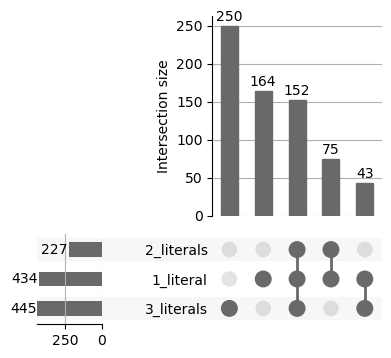

In [37]:
import upsetplot
from upsetplot import UpSet, plot, from_indicators
from upsetplot import from_contents
# angpain.values

# ang1 = angpain.set_index(angpain.pain_qc == True).set_index(angpain.pain2_qc == 1, append=True).set_index(angpain.pain_location_12_qc == 1, append=True)
# UpSet(ang1)
UpSet(from_indicators(pd.isna, data=ang1_up.iloc[:,0:]), show_counts=True, sort_by= 'cardinality', max_subset_size=1000, facecolor='dimgrey')
# upsetplot.query(ang1)
# upset = UpSet(angpain,element_size=32)